In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
%matplotlib inline

### Changes in the feature extraction/feature selection/processing

I have altered the `CountVectorizer` to discount stopwords and strip accents. I had tried it with `n_grams` as well but using the simple representation does not lead to a degradation in the preceived performance so I decided to use the simpler representation:

Since the documentation advises against the default stop words, I used custom stopwords from Kavita Ganesan from https://github.com/kavgan/nlp-in-practice/blob/master/tf-idf/resources/stopwords.txt 


```python

count = CountVectorizer(stop_words=new_stop_words, strip_accents='ascii')

```


In [2]:
import pandas as pd

class ProcessAmazon():
    """Read, filter, aggregate by ProductId, and generate X matrix"""

    def __init__(self, raw_data_filename, num_reviews_filter):
        """Initialize attributes."""
        self.raw_data_filename = raw_data_filename
        self.num_reviews_filter = num_reviews_filter
        self.raw_data = self.read_and_report()
        self.grouped_by_userid = self.group_by_userid()
        self.filtered = self.filter_()
        self.grouped_by_productid = self.group_by_productid()
        self.X = self.write_X()
    
    def read_and_report(self):
        """Read Amazon csv, report on file structure"""
        data = pd.read_csv(self.raw_data_filename)
        print(self.raw_data_filename, "has", data.shape[0], "rows and", data.shape[1], "columns. First five observations:")
        print(data.head(5))
        print(50 * '-')
        return data
    
    def group_by_userid(self):
        """Group by UserId and look at the distribution of number of reviews"""
        grouped_by_uid = self.raw_data.groupby('UserId').count()
        print('Distribution of number of reviews for each UserId:')
        print(grouped_by_uid['ProductId'].value_counts())
        print(50 * '-')
        return grouped_by_uid
    
    def filter_(self):
        """Filter out reviewers with fewer than x reviews"""
        filtered = self.grouped_by_userid[self.grouped_by_userid['Id'] > self.num_reviews_filter]
        # remove redundant columns
        filtered_final = filtered.drop(filtered.columns[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]], axis=1)
        # recreate UserId from index
        filtered_final['UserId'] = filtered_final.index
        # rename columns
        filtered_final.columns = ['num_reviews', 'UserId']
        filtered_final.reset_index(drop=True, inplace=True)
        # left merge filtered list with raw data
        filtered = pd.merge(filtered_final, self.raw_data, how='left', on='UserId')
        print("Filtered data has", filtered.shape[0], "rows and", filtered.shape[1], "columns. First five observations:")
        print(filtered.head(5))
        print(50 * '-')
        return filtered
    
    def group_by_productid(self):
        """Group by ProductId and create a column that lists each UserId (separated by spaces) who reviewed that product"""
        grouped_by_pid = self.filtered.groupby('ProductId')['UserId'].apply(lambda x: ' '.join(x)).reset_index()
        print("Data grouped by ProductId has", grouped_by_pid.shape[0], "rows and", grouped_by_pid.shape[1], "columns. First five observations:")
        print(grouped_by_pid.head(5))
        print(50 * '-')
        return grouped_by_pid
    
    def write_X(self):
        """use bag of words to create boolean X to represent reviews by UserId (one UserId per column)"""
        from sklearn.feature_extraction.text import CountVectorizer
            #custom stopwords Kavita Ganesan from https://github.com/kavgan/nlp-in-practice/blob/master/tf-idf/resources/stopwords.txt     
        new_stop_words = open('stopwords.txt','r').read().split('\n')
        count = CountVectorizer(stop_words=new_stop_words, strip_accents='ascii')
        uidArray = self.grouped_by_productid.UserId
        userFeatures = count.fit_transform(uidArray)
        print("Shape of final X matrix:", userFeatures.shape)
        return userFeatures

In [11]:
import pandas as pd
class ViewClusteringResults():
    """Merge cluster definitions to raw data and view samples of clustering results, showing review summaries and texts."""
    
    def __init__(self, data_instance, model_instance):
        """Initialize attributes"""
        self.data_instance = data_instance
        self.model_instance = model_instance
    
    def merge_labels(self):
        """Merge cluster labels to raw data (as structured in Amazon.csv)"""
        labels_tomerge = pd.DataFrame(self.model_instance.labels_)
        labelled_products = pd.concat([self.data_instance.grouped_by_productid, labels_tomerge], axis=1, ignore_index=True)
        labelled_products.columns = ['ProductId', 'UserIds', 'cluster']
        merged = pd.merge(labelled_products, self.data_instance.raw_data, how='left', on='ProductId')
        merged_lite = merged[['ProductId', 'cluster', 'Summary', 'Text']]
        return merged_lite

    def view_cluster_samples(self, n_samples):
        """Print x samples of cluster results for each cluster, showing details of product reviews."""
        merged = self.merge_labels()
        num_clusters = self.model_instance.cluster_centers_.shape[0]
        for i in range(1, num_clusters): 
            print(50 * '-')
            print('cluster: ', i)
            cluster = merged.loc[merged['cluster'] == i]
            print('cluster size: ', cluster.shape)
            print(cluster.sample(n_samples))

    def write_cluster_data(self):
        merged = self.merge_labels()
        # print(merged)
        num_clusters = self.model_instance.cluster_centers_.shape[0]
        # print(num_clusters)
        appended_data = []
        for i in range(1, num_clusters): 
            cluster = merged.loc[merged['cluster'] == i]
            appended_data.append(cluster)
        appended_data = pd.concat(appended_data)
        return appended_data
            

In [3]:
# process Amazon.csv, filtering out people who left 4 or fewer reviews
amazonData = ProcessAmazon('../../data/Amazon.csv', 4)

../../data/Amazon.csv has 455000 rows and 13 columns. First five observations:
   Unnamed: 0      Id   ProductId          UserId       ProfileName  \
0      138806  138807  B000E63LME  A1CQGW1AOD0LF2  Alena K. "Alena"   
1      469680  469681  B004ZIH4KM  A37S7U1OX2MCWI        Becky Cole   
2      238202  238203  B003ZXE9QA  A2OM6G73E64EQ9              jeff   
3      485307  485308  B001RVFERK  A25W349EE97NBK          Tangent4   
4      375283  375284  B000OQZNTS  A3CPPW0HUC07YS       Amy Nicolai   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       2      2  1294185600   
1                     0                       0      5  1349740800   
2                     0                       0      5  1329264000   
3                     1                       1      4  1248307200   
4                     0                       0      5  1333238400   

                     Summary  \
0           Not as pictured.   
1        

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['come', 'vis', 'viser', 'visest'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Shape of final X matrix: (30772, 18024)


### Fit kMeans iteratively and plot changes in inertia to begin to assess the appropriate number of clusters

Using the `tqdm` package to make the progess bar around the proces

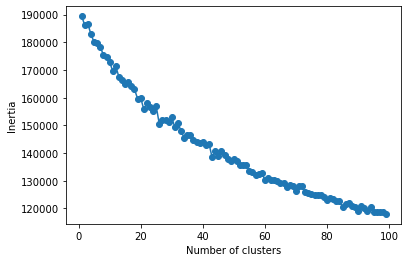

In [6]:
# first attempt at fitting K means to view change in Inertia
from sklearn.cluster import KMeans

# container to store inertia scores over iterations
distortions = []

# fit KMeans iteratively to begin to assess the appropriate number of clusters
for i in tqdm(range(1, 100)):
    km = KMeans(n_clusters=i)
    km.fit(amazonData.X)
    distortions.append(km.inertia_)
    
# vizualize change in inertia
plt.plot(range(1, 100), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

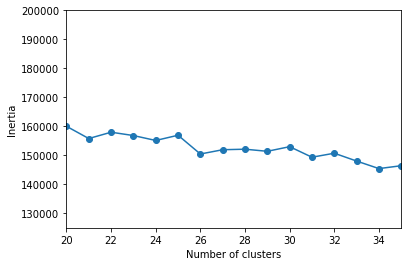

In [7]:
plt.plot(range(1, 100), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.axis((20,35,125000,200000))
plt.ylabel('Inertia')
plt.show()

### Choosing 26 for the value of the clusters as it seems like a area of potential "flattening" even though there is not a clear "elbow" in the plots

In [62]:
# fit KMeans with 26 clusters
from sklearn.cluster import KMeans
km_26 = KMeans(n_clusters=26, verbose = 1)
km_26.fit(amazonData.X)

Initialization complete
Iteration 0, inertia 199242.0
Iteration 1, inertia 163987.83313389777
Iteration 2, inertia 163293.90739974528
Iteration 3, inertia 162832.57929218473
Iteration 4, inertia 162677.04472657837
Iteration 5, inertia 162648.56640550375
Iteration 6, inertia 162623.18863399897
Iteration 7, inertia 162614.32284225847
Iteration 8, inertia 162610.62479448324
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 194096.0
Iteration 1, inertia 158236.96642706718
Iteration 2, inertia 157464.0529358582
Iteration 3, inertia 157399.76718622603
Iteration 4, inertia 157369.33905759017
Iteration 5, inertia 157346.15984011238
Iteration 6, inertia 157334.26323929636
Iteration 7, inertia 157330.73782703016
Iteration 8, inertia 157322.36588829785
Iteration 9, inertia 157319.22598101958
Iteration 10, inertia 157317.50116327504
Iteration 11, inertia 157315.43251422452
Iteration 12, inertia 157313.61470708757
Converged at iteration 12: strict convergenc

KMeans(n_clusters=26, verbose=1)

In [63]:
# create an instance of ViewClusteringResults to view results of final KMeans fit
viz = ViewClusteringResults(amazonData, km_26)

In [64]:
# view samples of product reviews, organized by KMeans cluster results
viz.view_cluster_samples(20)

y  \
136056                                                fyi   
9535                                                  fyi   
136083                         Good Inexpensive Cleanser.   
9780                            This is great quality tea   
364123                                     Red Clover Tea   
66544                                   Interesting taste   
135725                                   I Love Sage Tea!   
115605                        This stuff Smells so baaaad   
115517                                      Love this tea   
290339             useless - I feel no effects whatsoever   
23472                                        Rose Hip Tea   
17240                         Great herbal tea for cramps   
135618  Works, economical alternative to other 'diet' ...   
364151                                       nice product   
135685                               Birthing Miracle Tea   
9290                                      It warmed me up   
187285             

The clusters are making sense from the examples so far observed using the text data itself. However, after doing some reading on kmeans visualisation, I came across the `yellowbrick` package which is an wrapper for `scikit-learn` and `matplotlib` and allows us to create ML-specific visualisations using a high-level API. Source: [Yellowbrick](https://www.scikit-yb.org/en/latest/)

Using the `yellowbrick` package, I saw that an elbow existed at **3** but I decided that was too small to be considered as a clustering value (given that promising results I had with the earlier value of 26). Therefore, I ran the visualiser up to 100 clusters and was able to find a "better elbow" at **31**:

In [6]:
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

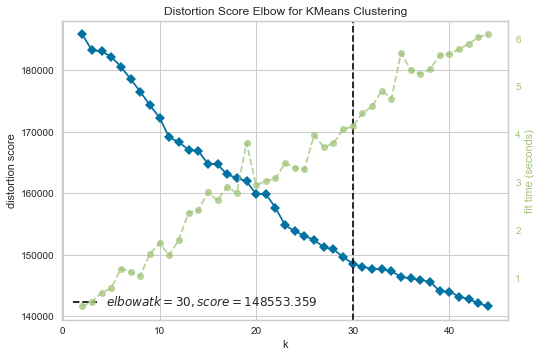

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 k=None, model=None)

In [8]:
from yellowbrick.cluster.elbow import kelbow_visualizer
kelbow_visualizer(KMeans(random_state=4), amazonData.X, k=(2,45))

### Using a clustering value of 30 and investigating its results:

In [9]:
# fit KMeans with 30 clusters
from sklearn.cluster import KMeans
km_30 = KMeans(n_clusters=30, verbose = 1)
km_30.fit(amazonData.X)

Initialization complete
Iteration 0, inertia 189106.0
Iteration 1, inertia 152634.67959792042
Iteration 2, inertia 152242.25320593105
Iteration 3, inertia 151521.1961114982
Iteration 4, inertia 151257.3692049119
Iteration 5, inertia 151177.42056104983
Iteration 6, inertia 151029.2213186825
Iteration 7, inertia 150981.51377857657
Iteration 8, inertia 150956.99490889348
Iteration 9, inertia 150931.77921305882
Iteration 10, inertia 150907.843866365
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 190054.0
Iteration 1, inertia 153771.98699598413
Iteration 2, inertia 152905.8492019626
Iteration 3, inertia 152524.91564537853
Iteration 4, inertia 152441.15562151314
Iteration 5, inertia 152401.0402929026
Iteration 6, inertia 152391.88623376514
Iteration 7, inertia 152383.05821854318
Iteration 8, inertia 152377.1053361958
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 187446.0
Iteration 1, inertia 150849.9976

KMeans(n_clusters=30, verbose=1)

## Investigating the results

In [12]:
# create an instance of ViewClusteringResults to view results of final KMeans fit
viz = ViewClusteringResults(amazonData, km_30)

In [13]:
# view samples of product reviews, organized by KMeans cluster results
viz.view_cluster_samples(20)

--------------------------------------------------
cluster:  1
cluster size:  (2059, 4)
        ProductId  cluster                               Summary  \
74277  B000H0ZJIG        1                          Dogs love it   
74462  B000H0ZJIG        1            Love Zuke's Mini Naturals!   
74318  B000H0ZJIG        1                    great for training   
19132  B0007A0AQM        1  Great for training, dog loves these!   
27195  B000BRR8VQ        1                Dries out very quickly   
74074  B000H0ZJHW        1         Smelly but good (for the dog)   
73971  B000H0ZJHW        1                           EXCELLENT !   
74114  B000H0ZJHW        1  Great for training, dog loves these!   
27333  B000BRR8VQ        1                 Perfect for Training!   
19520  B0007A0AQW        1                         dog loves 'em   
19529  B0007A0AQW        1                       Dogs love them.   
19237  B0007A0AQM        1                  perfect for training   
19202  B0007A0AQM        1  

cluster size:  (401, 4)
         ProductId  cluster                                           Summary  \
274008  B003M61F0I       25                                Excellent product!   
274093  B003M63C0E       25       Came highly recommended by our dogs breeder   
18301   B0006VSXBG       25                                Excellent product!   
274011  B003M61F0I       25                               Eagle Pack Holistic   
274003  B003M61F0I       25                       Refuting the 2-Star Review.   
4658    B0000TSQ6Q       25                                       Ingredients   
4626    B0000TSQ6G       25                                             Mold?   
4659    B0000TSQ6Q       25                     Good food for English bulldog   
18345   B0006VSXBQ       25                                         Just Okay   
18341   B0006VSXBQ       25                   Picky dog likes this as a treat   
18338   B0006VSXBQ       25                                Super for my Shiba   
2740

### Using a clustering value of 30

## Visualising the kMeans clustering 

#### All the cluster results are in the "test30.xlsx" file uploaded separately

In [132]:
viz = ViewClusteringResults(amazonData, km_30)

In [18]:
viz.write_cluster_data().to_excel('test30.xlsx')

In [29]:
data_xl = pd.read_excel('test30.xlsx')


In [30]:
data_xl.head()

,Unnamed: 0,ProductId,cluster,Summary,Text
0,19127,B0007A0AQM,1,"Gave my dog gas,","My dog seemed to like these, but not as much a..."
1,19128,B0007A0AQM,1,Great treats.,These are great treats when you want to use th...
2,19129,B0007A0AQM,1,AWESOME!!!,I didn't expect to get so many treats!!! They'...
3,19130,B0007A0AQM,1,Made my doggie very happy!,"I don't know about your dog, however my doggie..."
4,19131,B0007A0AQM,1,Toy Maltese hate salmon flavor,"I was training my maltese puppies, using chick..."


In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#custom stopwords Kavita Ganesan from https://github.com/kavgan/nlp-in-practice/blob/master/tf-idf/resources/stopwords.txt     
new_stop_words = open('stopwords.txt','r').read().split('\n')

def get_vect_counts(text):
    try:
        cv_xl.fit_transform([text])
        return cv_xl.vocabulary_
    except:
        return-1

cv_xl = CountVectorizer(stop_words=new_stop_words, strip_accents='ascii')
data_xl['word_count'] = data_xl['Text'].apply(get_vect_counts)



/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['come', 'vis', 'viser', 'visest'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [58]:
data_xl.head()

,Unnamed: 0,ProductId,cluster,Summary,Text,word_count
0,19127,B0007A0AQM,1,"Gave my dog gas,","My dog seemed to like these, but not as much a...","{'dog': 3, 'like': 8, 'snacks': 10, 'given': 7..."
1,19128,B0007A0AQM,1,Great treats.,These are great treats when you want to use th...,"{'great': 0, 'treats': 11, 'training': 10, 're..."
2,19129,B0007A0AQM,1,AWESOME!!!,I didn't expect to get so many treats!!! They'...,"{'didn': 5, 'expect': 7, 'treats': 19, 'small'..."
3,19130,B0007A0AQM,1,Made my doggie very happy!,"I don't know about your dog, however my doggie...","{'don': 4, 'know': 8, 'dog': 2, 'doggie': 3, '..."
4,19131,B0007A0AQM,1,Toy Maltese hate salmon flavor,"I was training my maltese puppies, using chick...","{'training': 28, 'maltese': 12, 'puppies': 16,..."


In [59]:
data_xl.to_excel('amazon_reviews_km30.xlsx')